# Basic Raster Operations

<style> p { text-align: justify; } </style>

Raster data represents continuous spatial information such as elevation, temperature, or land cover. In Python, the `rasterio` and `matplotlib` libraries provide efficient tools for working with raster data, allowing users to visualize, analyze, and manipulate raster layers. Some common operations include plotting, reclassification, clipping, and masking, among others. These operations enable users to extract specific information and tailor raster datasets to their analysis needs.

## Plotting

Visualizing raster data is an essential step in understanding its structure and distribution. Python provides tools to load and render raster layers intuitively, often with color palettes that reflect the range of values in the data. The example below demonstrates how to visualize raster data, such as ESA Land Cover data from 2015.

In [5]:
# Import required libraries
import rasterio
import matplotlib.pyplot as plt

# Load the raster data
raster_file = "data/raster/landcover_2015.tif"

with rasterio.open(raster_file) as src:
    raster_data = src.read(1)  # Read the first band (common for single-band rasters)

    # Metadata about the raster
    print(f"Raster CRS: {src.crs}")
    print(f"Dimensions: {src.width} x {src.height}")
    print(f"Bounds: {src.bounds}")
    print(f"Data Type: {src.read(1).dtype}")  

Raster CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Dimensions: 505 x 590
Bounds: BoundingBox(left=80.06051587301587, bottom=28.551587301587343, right=80.56150793650794, top=29.136904761904802)
Data Type: uint32


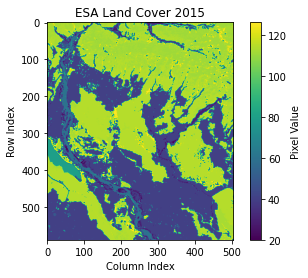

In [6]:
# Plot the raster using Matplotlib
plt.imshow(raster_data, cmap='viridis')
plt.colorbar(label="Pixel Value")  # Add a colorbar to indicate pixel values
plt.title("ESA Land Cover 2015")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

As seen in the plot above, the cell values range from 20 to over 120.

## Clipping

Clipping raster data allows you to extract a specific spatial region of interest from a larger raster dataset. This is particularly useful when working with large raster files where analysis is focused on a smaller area.

Python provides tools for clipping raster data using libraries such as rasterio and shapely. Below is an example of how to clip raster data with a polygon.

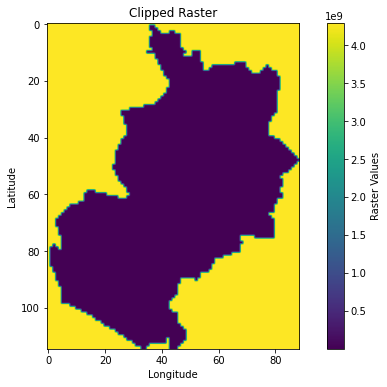

In [11]:
import rasterio.mask
import geopandas as gpd

# Define file paths
raster_path = "data/raster/landcover_2015.tif"
vector_path = "data/vector/sreepur.gpkg"

# Load the geopackage defining the clipping polygon
clip_polygon = gpd.read_file(vector_path)

# Open the raster file
with rasterio.open(raster_path) as src:

    # Convert the polygon to GeoJSON format and extract geometry
    clip_geometry = [geom.__geo_interface__ for geom in clip_polygon.geometry]

    # Clip the raster using rasterio.mask
    clipped_raster, clipped_transform = rasterio.mask.mask(src, clip_geometry, crop=True)
    clipped_meta = src.meta.copy()

# Update the metadata to reflect the new dimensions
clipped_meta.update({
    "driver": "GTiff",
    "height": clipped_raster.shape[1],
    "width": clipped_raster.shape[2],
    "transform": clipped_transform
})

# Visualize the clipped raster
plt.figure(figsize=(10, 6))
plt.imshow(clipped_raster[0], cmap="viridis")  # Use the first band of the clipped raster
plt.colorbar(label="Raster Values")
plt.title("Clipped Raster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

- The clipping polygon is converted to GeoJSON format `(__geo_interface__)`, which rasterio can use to define the clipping region.
- `rasterio.mask.mask()` is used to clip the raster. The crop=True argument ensures that only the extent of the polygon is retained.

## Reclassification

Reclassification is the process of modifying raster values based on a defined mapping. It is commonly used to group or reassign classes, such as land cover types, to simplify analysis or standardize data. For example, a raster of population count values can be reclassified into categories such as “Low,” “Medium,” and “High.” And a raster of Land cover values can be reclassified into their original land cover type categories.

For our case, we are using WorldPop Population Count data from year 2020, which consists of continuous values. Before performing reclassification, it is important to inspect the raster values (minimum and maximum) present in the raster dataset.

In [38]:
import numpy as np 

raster_file = "data/raster/popCount_2020.tif"
# open the raster file
with rasterio.open(raster_file) as src:

    # Read the raster data as a numpy array
    raster_data = src.read(1) # Single band raster

    # Mask invalid or nodata values 
    # Define a custom condition for masking (e.g., mask zeros)
    masked_data = np.ma.masked_where((raster_data == 0) | np.isnan(raster_data), raster_data)

    # Calculate summary statistics
    min_value = masked_data.min()
    max_value = masked_data.max()
    mean_value = masked_data.mean()
    median_value = np.ma.median(masked_data)

    # Print the results
    print(f"Minimum value: {min_value}")
    print(f"Maximum value: {max_value}")
    print(f"Mean value: {mean_value}")
    print(f"Median value: {median_value}")

Minimum value: 0.1460667997598648
Maximum value: 136.91754150390625
Mean value: 5.2824760935231385
Median value: 2.4147253036499023


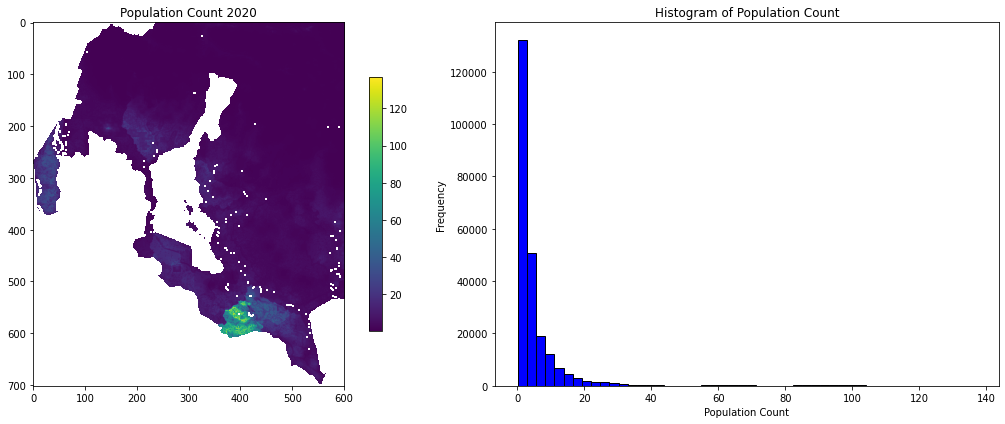

In [39]:
# Create subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot the raster data on the first axis
im = axes[0].imshow(masked_data, cmap="viridis")
axes[0].set_title("Population Count 2020")
fig.colorbar(im, ax=axes[0], shrink=0.7)

# Plot the histogram on the second axis
axes[1].hist(masked_data.compressed(), bins=50, color='blue', edgecolor='black')
axes[1].set_title("Histogram of Population Count")
axes[1].set_xlabel("Population Count")
axes[1].set_ylabel("Frequency")

# Adjust layout and display
plt.tight_layout()
plt.show()

Since we have already inspected the raster values, here's how we can classify the population count raster into multiple classes based on specific value ranges:

In [36]:
import matplotlib.colors as mcolors

# Define classification thresholds
def classify(value):
    if value < 0.5:
        return 1        # "Very Low"
    elif value < 5:
        return 2        # "Low"
    elif value < 20:
        return 3        # "Medium"
    elif value < 50:
        return 4        # "High"
    elif value < 100:
        return 5        # "Very High"
    else:
        return 6        # "Highly Dense"

# Open the raster file
with rasterio.open("data/raster/popCount_2020.tif") as src:
    raster_data = src.read(1)

    # Mask invalid or nodata values 
    # Define a custom condition for masking (e.g., mask zeros)
    masked_data = np.ma.masked_where((raster_data == 0) | np.isnan(raster_data), raster_data)

    # Classify the raster values
    classified_raster = np.vectorize(classify)(masked_data.filled(-1))

    # Display the classified data counts
    unique, counts = np.unique(classified_raster, return_counts=True)
    print("Class Distribution:")
    for cls, count in zip(unique, counts):
        print(f"{cls}: {count}")


Class Distribution:
1: 237889
2: 120112
3: 53108
4: 7640
5: 2604
6: 549


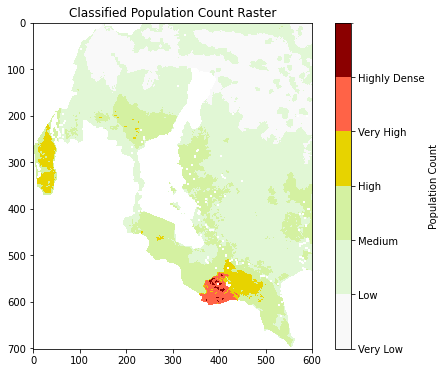

In [37]:
# Visualize classified raster
# Create a color map for classification
cmap = mcolors.ListedColormap(['#f9f9f9', '#e1f7d5', '#d4f1a1', '#e7d300', '#ff6347', '#8b0000'])
bounds = [0, 0.5, 5, 20, 50, 100, 137]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create a figure and plot the classified raster
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(masked_data, cmap=cmap, norm=norm)

# Add colorbar with labels
cbar = fig.colorbar(cax, ax=ax, ticks=[0.25, 2.5, 10, 30, 75, 115])
cbar.set_label('Population Count')

# Correctly align the tick labels with their respective colors
cbar.set_ticks([0, 0.5, 5, 20, 50, 100])
cbar.set_ticklabels(["Very Low", "Low", "Medium", "High", "Very High", "Highly Dense"])

# Add title
ax.set_title("Classified Population Count Raster")
plt.show()

## Saving Data to File

We can use the `rasterio` to save raster data to a file.

In [34]:
# Replace any classified value of -1 with the NoData value (e.g., -9999)
classified_raster[classified_raster == -1] = -9999  # Use -9999 as a sentinel NoData value

# Define the metadata for the new raster file (to save the classified data)
meta = src.meta  # Using the original raster's metadata
meta.update({
    'dtype': 'int32',  # The data type for the new classified raster
    'count': 1,  # Single band in the output raster
    'nodata': -9999 # Set the NoData value for the output raster
})

# Path to save the classified raster file
output_path = "data/raster/classified_population_raster.tif"

# Save the classified raster to a new file
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(classified_raster, 1)  # Write the classified raster data to the first band

## Zonal statistics

Zonal statistics is a technique in spatial analysis used to summarize raster values within specified zones, defined by a vector dataset (e.g., polygons). This operation is essential for combining raster data (e.g., elevation, land cover) with vector zones (e.g., administrative boundaries, land parcels). Some of the common applications of zonal statistics are:

- Calculate average elevation within administrative regions.
- Sum rainfall or temperature within watershed boundaries.
- Count the number of pixels of a certain land cover type within specific zones.
- Determine the majority or range of raster values for each zone.

To compute zonal statistics say for a given population count raster and a multipolygon geopackage file i.e. Kanchanpur district, you can use libraries like `rasterio`, `geopandas`, and `rasterstats` in Python. Here is a step-by-step guide to compute zonal statistics:

In [41]:
import rasterstats as rs

# Load the vector data (Kanchanpur district)
vector_file = "data/vector/kanchanpur.gpkg"
vector_data = gpd.read_file(vector_file)

# Load the raster data (population count raster)
raster_file = "data/raster/popCount_2020.tif"

# Use rasterstats to calculate zonal statistics - Calculate sum of raster values for each zone
zonal_stats = rs.zonal_stats(vector_data, raster_file, stats=["sum"])

# Add the zonal statistics to the vector data
zonal_stats_df = gpd.GeoDataFrame(vector_data)
zonal_stats_df["Population"] = [z["sum"] for z in zonal_stats]

# Print the total population
print(zonal_stats_df[['NAME', 'Population']].head())

           NAME    Population
0  BaisiBichawa  37900.042969
1      Beldandi  46565.355469
2      Chandani  72813.015625
3        Daijee  49223.929688
4   Dekhatbhuli  52221.738281


- `rasterstats` library can handle many statistics `("mean", "min", "max", "std")`, so you can adjust the stats argument to compute any specific statistics you need.

Lets create a barplot to analyze the population values within the zones.

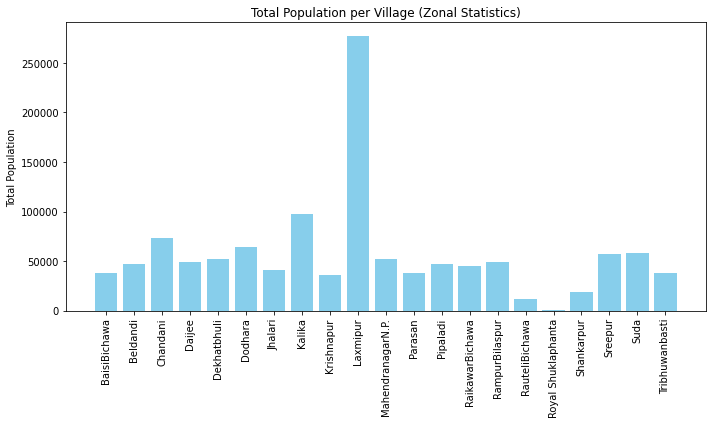

In [46]:
# Create a bar plot of total population for each polygon
plt.figure(figsize=(10, 6))
plt.bar(zonal_stats_df['NAME'], zonal_stats_df['Population'], color='skyblue')

# Add labels and title
plt.ylabel('Total Population')
plt.title('Total Population per Village (Zonal Statistics)')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()

From the barplot above, we can see that Laxmipur has the highest population, while Royal Shuklaphanta has the lowest population among all the VDCs in the Kanchanpur district.

**For this tutorial, this concludes the coverage of raster data operations. If you would like to explore additional operations, examples, or need clarification on any of the steps covered, please visit the GitHub repository: [Python_tutorial](https://github.com/Ohm-Np/Python_tutorial) and feel free to open an issue.**